In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
from urllib.parse import urlencode
import requests

In [2]:
df_group_add_url = "https://disk.yandex.ru/d/5Kxrz02m3IBUwQ" #pd.read_csv('group_add.csv')

In [3]:
def get_ydisk_url(public_key):
        base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
        final_url = base_url + urlencode(dict(public_key=public_key))
        response = requests.get(final_url)
        download_url = response.json()['href']
        return download_url

In [4]:
df_group_add = pd.read_csv(get_ydisk_url(df_group_add_url),
                            names=['id', 'grp'], header=0)
df_groups = pd.read_csv('groups.csv',sep=';')
df_activ = pd.read_csv('active_studs.csv')
df_checks = pd.read_csv('checks.csv',sep=';')

In [5]:
def make_df_and_metricks(group, group_add, activ, checks):
    """
    Функция для объединения данных и расчета метрик для активных пользователей
    
    Parameters:
    group, group_add - данные о группах пользователей
    activ - данные об активности 
    checks - данные о платежах
    
    Returns:
    DataFrame с метриками по группам
    """
    # Объединяем группы
    df = pd.concat([group, group_add])
    # Добавляем данные об активности
    df_ac = df.merge(activ, left_on='id', right_on='student_id', how='left')
    # Добавляем данные о платежах
    data = df_ac.merge(checks, left_on='id', right_on='student_id', how='left')
    # Переименовываем столбцы
    data.columns = ['id', 'group', 'activ', 'checks', 'rev']
    # Заполняем пропуски нулями
    data[['activ', 'checks', 'rev']] = data[['activ', 'checks', 'rev']].fillna(0)
    # Преобразуем в бинарные признаки
    data['activ'] = data['activ'].apply(lambda x: 1 if x > 0 else 0)
    data['checks'] = data['checks'].apply(lambda x: 1 if x > 0 else 0)
    # Фильтруем активных пользователей и считаем метрики
    result = data.query('activ == 1').groupby('group', as_index=False).agg(
        count=('id', 'count'),           # Количество активных пользователей
        CR=('checks', 'mean'),           # Conversion Rate
        ARPU=('rev', 'mean'),            # Average Revenue Per User
        ARPPU=('rev', lambda x: x[x > 0].mean() if len(x[x > 0]) > 0 else 0)  # ARPPU
    )
    return result

In [6]:
data=make_df_and_metricks(df_groups,df_group_add,df_activ,df_checks)

In [7]:
def visual_data(data_metricks):
    """Функция для визцализации метрик"""
    sns.set(style="whitegrid")
    fig, axs = plt.subplots(nrows= 1 , ncols= 3, figsize = (15, 6)) 

    axs[0].bar(data_metricks.group,data_metricks.ARPU, color=['green', 'orange'], alpha=0.6)
    axs[0].set_title('ARPU')

    axs[1].bar(data_metricks.group, data_metricks.ARPPU, color=['green', 'orange'], alpha=0.6)
    axs[1].set_title('ARPPU')

    axs[2].bar(data_metricks.group, data_metricks.CR, color=['green', 'orange'], alpha=0.6)
    axs[2].set_title('CR')

    plt.show()



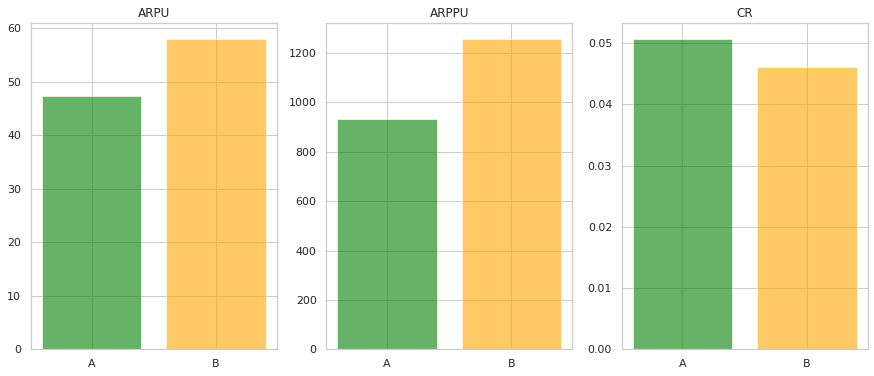

In [8]:

visual_data(data)

